In [1]:
import sys
sys.path.append('../..')

from common.toronto_api import TorontoOpenDataAPI
from common.data_processors import FerryDataProcessor
import ferry_tickets.src.ferry_analysis as an

import pandas as pd

In [2]:
# Initialize API client and get package metadata using id
client = TorontoOpenDataAPI('toronto-island-ferry-ticket-counts')
# Check resources in package
# client.show_resources_info()

In [3]:
# Get data from first listed resource, which is the active datastore
df = client.get_resource_data()
df.head()

,_id,Timestamp,Redemption Count,Sales Count
0,1,2024-11-29T11:30:00,23,25
1,2,2024-11-29T11:15:00,7,1
2,3,2024-11-29T11:00:00,5,8
3,4,2024-11-29T10:45:00,1,0
4,5,2024-11-29T10:30:00,28,22


In [4]:
# Process data using data processor
df = FerryDataProcessor().process_resource(df)
df.head()


latest:	2024-11-29
today:	2024-11-29


,_id,Timestamp,Redemption Count,Sales Count,datetimeTimestamp,isToday,isLatest
0,1,2024-11-29T11:30:00,23,25,2024-11-29 11:30:00,True,True
1,2,2024-11-29T11:15:00,7,1,2024-11-29 11:15:00,True,True
2,3,2024-11-29T11:00:00,5,8,2024-11-29 11:00:00,True,True
3,4,2024-11-29T10:45:00,1,0,2024-11-29 10:45:00,True,True
4,5,2024-11-29T10:30:00,28,22,2024-11-29 10:30:00,True,True


In [5]:
# Update saved csv
df.to_csv(
    '../data/processed/Toronto Island Ferry Ticket Counts.csv',
    header=True,
    index=False
)


---

In [6]:
# Add time-based features
df['Timestamp'] = df['datetimeTimestamp']
# df.drop(columns=['datetimeTimestamp'], inplace=True)
df['date'] = df['Timestamp'].dt.date
df['month'] = df['Timestamp'].dt.month
df['year'] = df['Timestamp'].dt.year
df['season'] = pd.cut(
    df['Timestamp'].dt.month, 
    bins=[0,3,6,9,12], 
    labels=['Winter', 'Spring', 'Summer', 'Fall']
)
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.day_name()


In [7]:
hourly = (df
    .groupby(
        ['season', 'day_of_week', 'date', 'hour'],
        observed=False
    )
    .agg({
        'Sales Count': 'sum',
        'Redemption Count': 'sum'
    })
    .reset_index()
)
hourly

,season,day_of_week,date,hour,Sales Count,Redemption Count
0,Winter,Friday,2015-05-01,0,0,0
1,Winter,Friday,2015-05-01,1,0,0
2,Winter,Friday,2015-05-01,2,0,0
3,Winter,Friday,2015-05-01,3,0,0
4,Winter,Friday,2015-05-01,4,0,0
...,...,...,...,...,...,...
2349307,Fall,Wednesday,2024-11-29,19,0,0
2349308,Fall,Wednesday,2024-11-29,20,0,0
2349309,Fall,Wednesday,2024-11-29,21,0,0
2349310,Fall,Wednesday,2024-11-29,22,0,0


In [8]:
hourly.index

RangeIndex(start=0, stop=2349312, step=1)

In [9]:
def isItPeak(
        df: pd.DataFrame,
        groupby_cols: list,
        col_name: str = 'isMax',
        value_col: str = 'Redemption Count'
    ) -> pd.DataFrame:
    result = df.copy()
    result[col_name] = result.index.isin(
        result.groupby(groupby_cols)[value_col].idxmax()
    )
    return result

In [10]:
hourly['year'] = pd.to_datetime(hourly['date']).dt.year

In [11]:
hourly

,season,day_of_week,date,hour,Sales Count,Redemption Count,year
0,Winter,Friday,2015-05-01,0,0,0,2015
1,Winter,Friday,2015-05-01,1,0,0,2015
2,Winter,Friday,2015-05-01,2,0,0,2015
3,Winter,Friday,2015-05-01,3,0,0,2015
4,Winter,Friday,2015-05-01,4,0,0,2015
...,...,...,...,...,...,...,...
2349307,Fall,Wednesday,2024-11-29,19,0,0,2024
2349308,Fall,Wednesday,2024-11-29,20,0,0,2024
2349309,Fall,Wednesday,2024-11-29,21,0,0,2024
2349310,Fall,Wednesday,2024-11-29,22,0,0,2024


In [12]:
isItPeak(hourly, ['year', 'season'], 'isMaxSeasonYear')

/var/folders/br/_k62f9c53h5bc9905_v1l3j80000gp/T/ipykernel_10945/862717270.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result.groupby(groupby_cols)[value_col].idxmax()


,season,day_of_week,date,hour,Sales Count,Redemption Count,year,isMaxSeasonYear
0,Winter,Friday,2015-05-01,0,0,0,2015,True
1,Winter,Friday,2015-05-01,1,0,0,2015,False
2,Winter,Friday,2015-05-01,2,0,0,2015,False
3,Winter,Friday,2015-05-01,3,0,0,2015,False
4,Winter,Friday,2015-05-01,4,0,0,2015,False
...,...,...,...,...,...,...,...,...
2349307,Fall,Wednesday,2024-11-29,19,0,0,2024,False
2349308,Fall,Wednesday,2024-11-29,20,0,0,2024,False
2349309,Fall,Wednesday,2024-11-29,21,0,0,2024,False
2349310,Fall,Wednesday,2024-11-29,22,0,0,2024,False


In [13]:
hourly

,season,day_of_week,date,hour,Sales Count,Redemption Count,year
0,Winter,Friday,2015-05-01,0,0,0,2015
1,Winter,Friday,2015-05-01,1,0,0,2015
2,Winter,Friday,2015-05-01,2,0,0,2015
3,Winter,Friday,2015-05-01,3,0,0,2015
4,Winter,Friday,2015-05-01,4,0,0,2015
...,...,...,...,...,...,...,...
2349307,Fall,Wednesday,2024-11-29,19,0,0,2024
2349308,Fall,Wednesday,2024-11-29,20,0,0,2024
2349309,Fall,Wednesday,2024-11-29,21,0,0,2024
2349310,Fall,Wednesday,2024-11-29,22,0,0,2024


In [14]:
# Update saved hourly data
hourly.to_csv(
    '../data/processed/hourly_ferry.csv',
    header=True,
    index=False
)


---


In [15]:
# Use script to generate analyses
analyses = an.analyze_ferry_patterns(df)


/Users/taniab/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/taniab/anaconda3/envs/dev/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


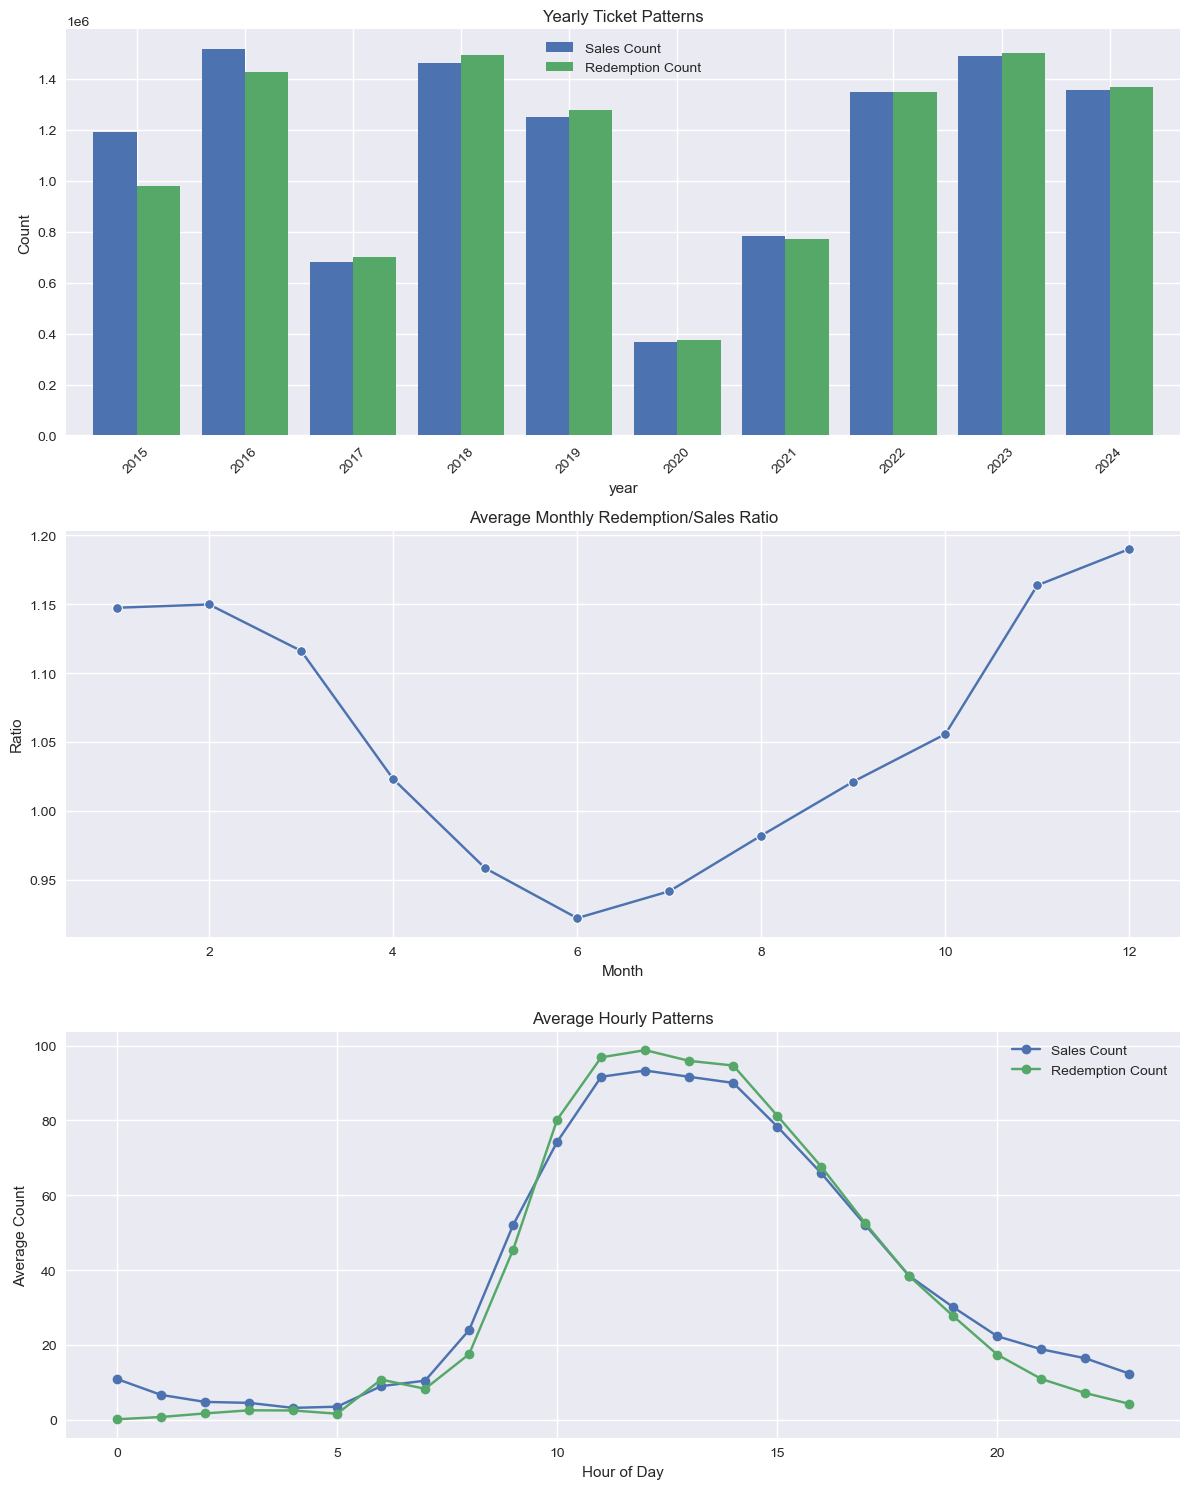

In [16]:
fig1 = an.plot_patterns(analyses)


In [17]:
insights = an.generate_insights(analyses)
insights

{'years_with_excess_redemptions': [2017, 2018, 2019, 2020, 2022, 2023, 2024],
 'max_redemption_ratio': {'value': 1.0242032634469902, 'year': 2017},
 'avg_monthly_ratio': 1.0529138434196343,
 'peak_hour': {'redemptions': 12, 'sales': 12}}

In [18]:

# Create monthly aggregations
monthly_stats = df.groupby(['year', 'month'], observed=True).agg({
    'Sales Count': 'sum',
    'Redemption Count': 'sum'
}).reset_index()

# Calculate monthly averages by season
seasonal_patterns = df.groupby(['season', 'month'], observed=True).agg({
    'Sales Count': 'mean',
    'Redemption Count': 'mean'
}).round(2)

In [19]:
# Peak usage analysis by season
seasonal_hourly = df.groupby(['season', 'hour'], observed=True).agg({
    'Sales Count': 'mean',
    'Redemption Count': 'mean'
}).round(2)

# Find peak hours for each season
peak_hours = seasonal_hourly.groupby('season', observed=True)['Redemption Count'].idxmax()

In [20]:
# Calculate year-over-year growth
yearly_stats = df.groupby('year')[['Sales Count', 'Redemption Count']].sum()
yearly_growth = yearly_stats.pct_change() * 100

In [21]:
# Calculate YoY growth for each month
monthly_stats['previous_year_sales'] = monthly_stats.groupby('month')['Sales Count'].shift(1)
monthly_stats['yoy_growth'] = ((monthly_stats['Sales Count'] - monthly_stats['previous_year_sales']) 
                              / monthly_stats['previous_year_sales'] * 100).round(2)

In [22]:
yearly_stats

,Sales Count,Redemption Count
year,,
2015,1189620,978707
2016,1518428,1425779
2017,682346,698861
2018,1463589,1493560
2019,1249725,1278505
2020,366606,374546
2021,782368,773040
2022,1346659,1349778
2023,1491473,1502883


In [23]:
yearly_growth

,Sales Count,Redemption Count
year,,
2015,NaN,NaN
2016,27.639751,45.679861
2017,-55.062341,-50.983918
2018,114.493673,113.713457
2019,-14.612299,-14.398819
2020,-70.665066,-70.704377
2021,113.408400,106.393874
2022,72.126033,74.606489
2023,10.753576,11.342976
